## Cost sensitive learning with cross-validation and hyperparameter tuning

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

In this notebook, we'll test the power of cost sensitive learning across many datasets. We'll optimize the hyperparameters of ensemble models as well as the cost.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from imblearn.datasets import fetch_datasets

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
datasets_ls = [
    'ecoli',
    'optical_digits',
    'satimage',
    'pen_digits',
    'abalone',
    'sick_euthyroid',
    'spectrometer',
    'car_eval_34',
    'isolet',
    'us_crime',
    'yeast_ml8',
    'scene',
    'libras_move',
    'thyroid_sick',
    'coil_2000',
    'arrhythmia',
    'solar_flare_m0',
    'oil',
    'car_eval_4',
    'wine_quality',
    'letter_img',
    'yeast_me2',
    'webpage',
    'ozone_level',
    'mammography',
    'protein_homo',
    'abalone_19',
]

len(datasets_ls)

27

In [3]:
# Classical ensemble models

ensemble_dict = {

    'random_forests': RandomForestClassifier(random_state=39),

    'xgb': XGBClassifier(random_state=39),

    'lightgbm': LGBMClassifier(random_state=39),
}

In [4]:
params = {
    "n_estimators": [10, 50, 100, 500],
    "max_depth": [1, 2, 3, 4],
    "class_weight": [
        None,  # cost in-sensitive
        "balanced",
        {0: 1, 1: 10},
        {0: 1, 1: 100},
        {0: 1, 1: 1000},
        {0: 1, 1: 10000},
    ]
}

# xgb doesn't have the class_weight param
xgb_params = {
    "n_estimators": [10, 50, 100, 500],
    "max_depth": [1, 2, 3, 4],
}

In [6]:
# now we train several models, with the different ensembles
# with cross-validation for each dataset

# to store the results
mean_dict = {}
std_dict = {}
model_dict = {}


for dataset in datasets_ls:

    # initiate a dictionary per dataset
    mean_dict[dataset] = {}
    std_dict[dataset] = {}
    model_dict[dataset] = {}

    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,
        data.target,
        test_size=0.3,
        random_state=0,
    )

    # xgboost does not like that one of the classes
    # values is -1, so I need to remap to 0 and 1.
    y_train = np.where(y_train < 0, 0, 1)

    for ensemble in ensemble_dict.keys():

        print(ensemble)

        model = ensemble_dict[ensemble]

        if ensemble == "xgb":
            params_ = xgb_params
        else:
            params_ = params

        # train and evaluate performance
        # with cross-validation
        search = RandomizedSearchCV(
            model,
            params_,
            scoring="roc_auc",
        )

        search.fit(X_train, y_train)

        print('Best parameters: {0}, \n Best score: {1}'.format(
            search.best_params_, search.best_score_))

        m, s = pd.DataFrame(search.cv_results_).sort_values(
            by="mean_test_score",
            ascending=False).loc[0, ["mean_test_score", "std_test_score"]].values

        # if the best model used cost sensitive learning, add
        # tag to name
        if ensemble != "xgb" and search.best_estimator_.class_weight is not None:
            model_name = ensemble+"_cs"
        else:
            model_name = ensemble

        # store results
        mean_dict[dataset][model_name] = m
        std_dict[dataset][model_name] = s
        model_dict[dataset][model_name] = search

        print()

    print()

ecoli
random_forests
Best parameters: {'n_estimators': 500, 'max_depth': 4, 'class_weight': None}, 
 Best score: 0.9253193960511034

xgb
Best parameters: {'n_estimators': 100, 'max_depth': 1}, 
 Best score: 0.92137049941928

lightgbm
Best parameters: {'n_estimators': 50, 'max_depth': 1, 'class_weight': {0: 1, 1: 10}}, 
 Best score: 0.9212775842044134


optical_digits
random_forests
Best parameters: {'n_estimators': 10, 'max_depth': 4, 'class_weight': 'balanced'}, 
 Best score: 0.9747694910515827

xgb
Best parameters: {'n_estimators': 500, 'max_depth': 3}, 
 Best score: 0.9988138235953639

lightgbm
Best parameters: {'n_estimators': 500, 'max_depth': 3, 'class_weight': {0: 1, 1: 1000}}, 
 Best score: 0.9984797688141492


satimage
random_forests
Best parameters: {'n_estimators': 500, 'max_depth': 4, 'class_weight': 'balanced'}, 
 Best score: 0.9318960050729233

xgb
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.9469804028142645

lightgbm
Best parameters: {'n_estim

Best parameters: {'n_estimators': 500, 'max_depth': 4, 'class_weight': {0: 1, 1: 10}}, 
 Best score: 0.970103082155726


ozone_level
random_forests
Best parameters: {'n_estimators': 500, 'max_depth': 3, 'class_weight': {0: 1, 1: 10}}, 
 Best score: 0.8856113000582161

xgb
Best parameters: {'n_estimators': 100, 'max_depth': 2}, 
 Best score: 0.901860036155284

lightgbm
Best parameters: {'n_estimators': 100, 'max_depth': 3, 'class_weight': {0: 1, 1: 10}}, 
 Best score: 0.8909392100989674


mammography
random_forests
Best parameters: {'n_estimators': 100, 'max_depth': 2, 'class_weight': 'balanced'}, 
 Best score: 0.9266026490846635

xgb
Best parameters: {'n_estimators': 50, 'max_depth': 3}, 
 Best score: 0.9481012241803608

lightgbm
Best parameters: {'n_estimators': 100, 'max_depth': 4, 'class_weight': {0: 1, 1: 10}}, 
 Best score: 0.9434272238229072


protein_homo
random_forests
Best parameters: {'n_estimators': 100, 'max_depth': 4, 'class_weight': {0: 1, 1: 100}}, 
 Best score: 0.984333

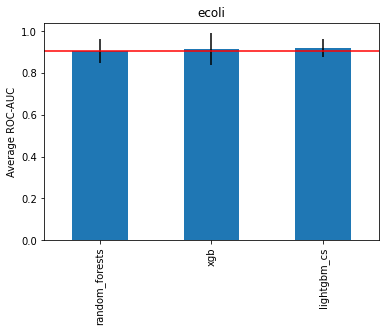

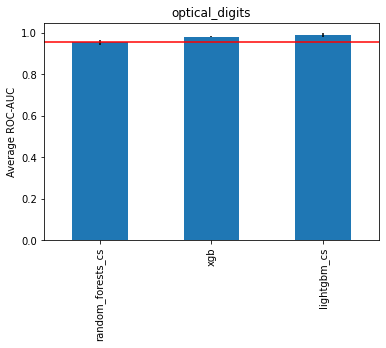

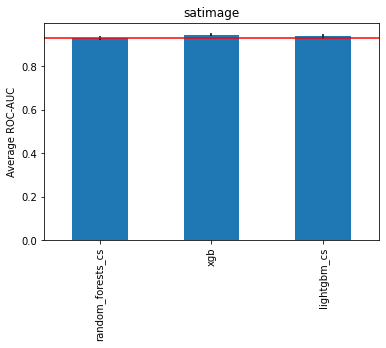

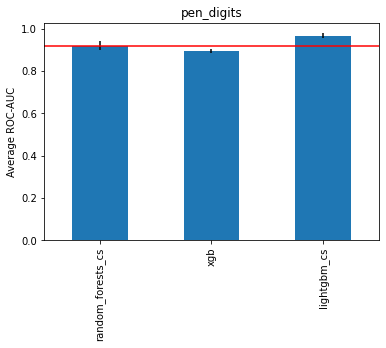

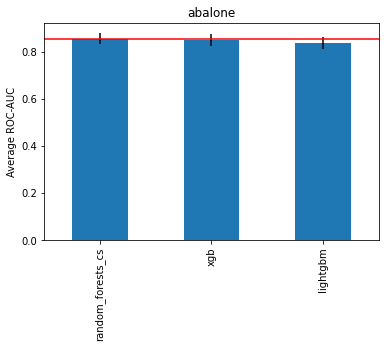

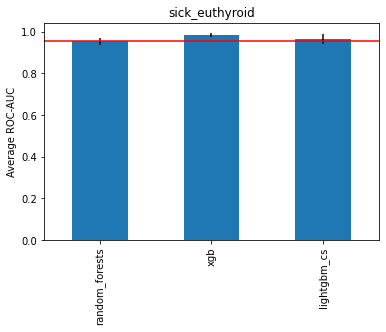

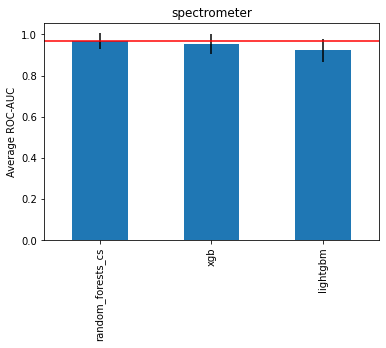

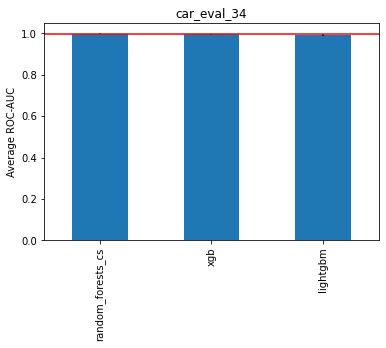

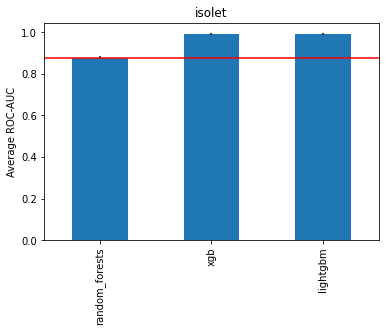

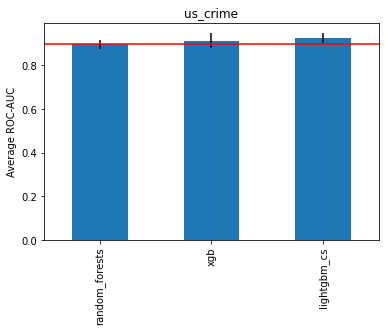

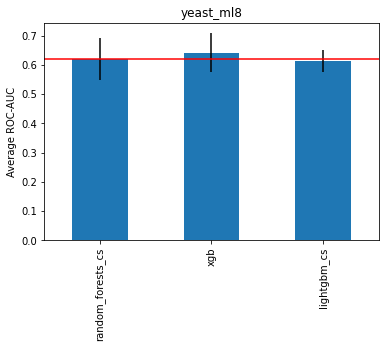

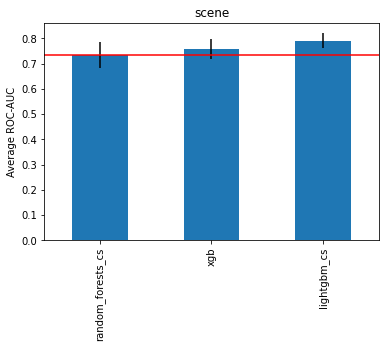

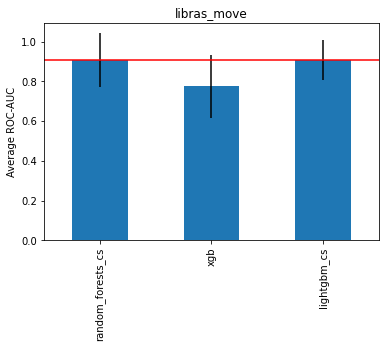

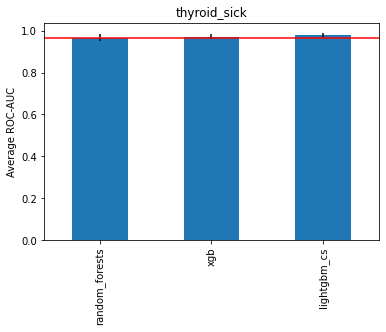

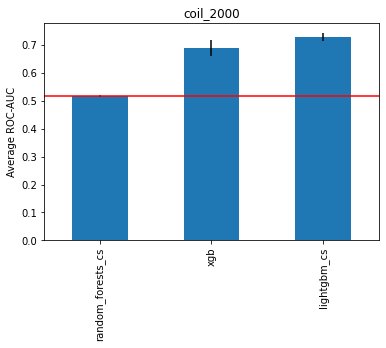

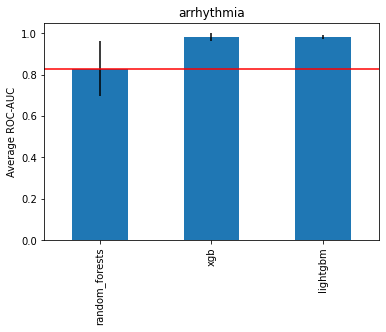

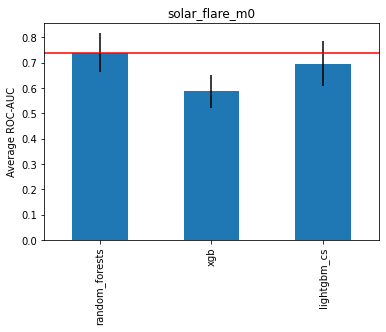

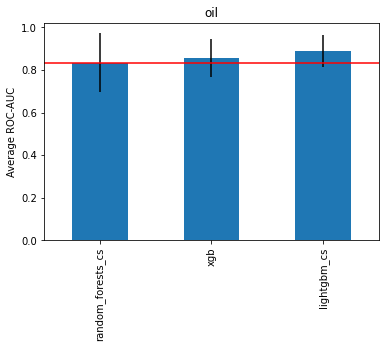

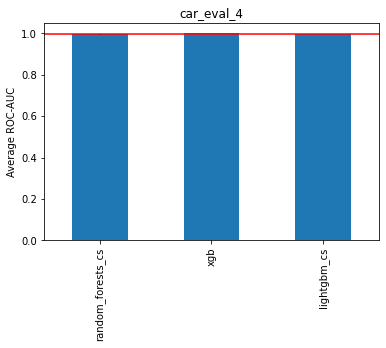

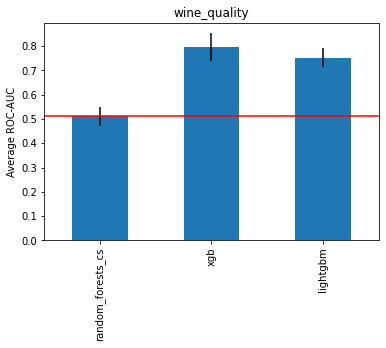

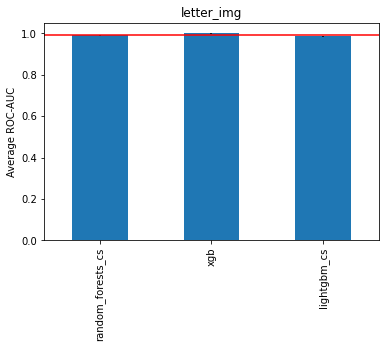

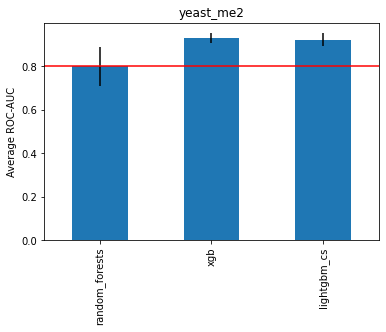

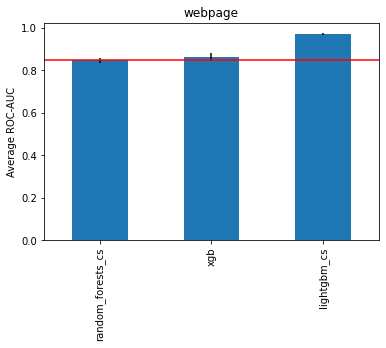

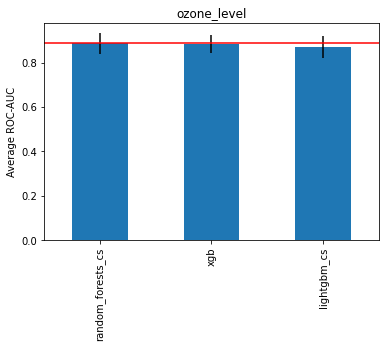

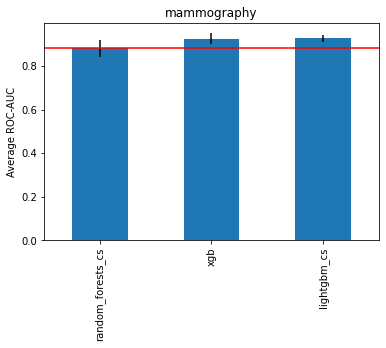

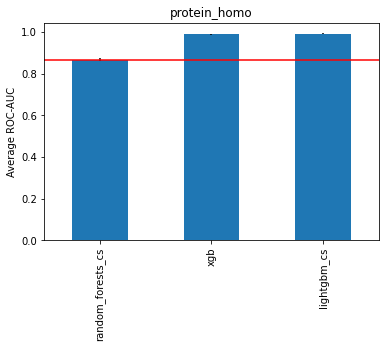

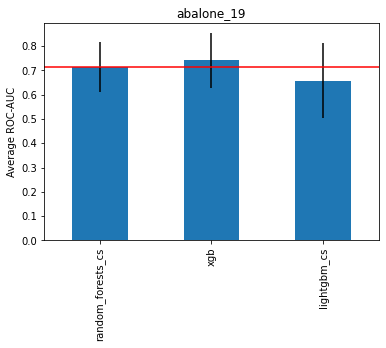

In [9]:
# Now we plot the performance of the models

for dataset in datasets_ls:
    
    mean_s = pd.Series(mean_dict[dataset])
    std_s = pd.Series(std_dict[dataset])
    
    mean_s.plot.bar(yerr=[std_s, std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average ROC-AUC')
    try:
        plt.axhline(mean_dict[dataset]['random_forests'], color='r')
    except:
        plt.axhline(mean_dict[dataset]['random_forests_cs'], color='r')
    plt.show()

In most datasets, the 3 types of ensembles performed roughly the same in terms of roc-auc.

- For lightGBMs, the model with cost-sensitive learning almost always outperformed the cost-insensitive lightGBM.

- For random forests, the model with cost-sensitive learning often returned better performance than the the cost-insensitive model.

- In 8 datasets, lightGBM (often with cost-sensitive learning) outperformed random forests, and in 2, it also outperformed the cost-insensitive xgboost.

It will be interesting to compare the results from this notebook, with the results of models trained after resampling, which we'll do in coming sections.

In [8]:
import pickle 

with open('cs_mean.pkl', 'wb') as f:
    pickle.dump(mean_dict, f)

with open('cs_std.pkl', 'wb') as f:
    pickle.dump(std_dict, f)
    
with open('cs_model.pkl', 'wb') as f:
    pickle.dump(model_dict, f)